# Estimating hotspot(s) emission and rotational axis from visibilties. 

Notes:
Inner most stable circular orbit (ISCO), for spin=0 with r_g=2 this is at 3M \
Overleaf notes: https://www.overleaf.com/project/60ff0ece5aa4f90d07f2a417

In [1]:
import sys
sys.path.append('../bhnerf')

import os

import jax
from jax import random
from jax import numpy as jnp
import jax.scipy.ndimage as jnd
import scipy.ndimage as nd

os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3'

import xarray as xr
import flax
from flax.training import train_state
from flax.training import checkpoints
import optax
import numpy as np
import matplotlib.pyplot as plt

import utils, emission_utils, visualization, network_utils, observation_utils
from network_utils import shard

import ehtim as eh
import ehtim.const_def as ehc
from tensorboardX import SummaryWriter
from datetime import datetime
from tqdm.notebook import tqdm
import ipyvolume as ipv
from ipywidgets import interact
import ipywidgets as widgets

import yaml
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import glob, yaml

from ehtim.observing.obs_helpers import ftmatrix
# from jax.config import config
# config.update("jax_debug_nans", True)
%load_ext autoreload
%autoreload 2

2021-11-05 11:43:11.008817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ghcwd572 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to eht-imaging! v 1.2.2 



In [2]:
# Generate hotspot emission (fancy, 4 sheared + 4 new hotspots)
nt, nx, ny, nz = 128, 64, 64, 64
nt_test = 128
r_isco = 3.0 

phi = np.pi/5               # azimuth angle (ccw from x-axis)
theta = np.pi/2 + np.pi/3   # zenith angle (pi/2 = equatorial plane)
orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame_single = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco, std_clip=np.inf)
rot_axis = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])

nspots = 4
# Generated by np.random.choice(range(0, 128, 5), size=nspots, replace=False) 
# with np.random.seed(123456)
frame_subset_inds = np.array([125,  65, 115,  15]) 
# Sum over rotated positions of n_spots
initial_frame_nspots = emission_utils.generate_orbit_3d(initial_frame_single, nt, 1, rot_axis).isel(
    t=frame_subset_inds).sum('t')

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)

# Shear initial hotspots
normalization_factor = 0.01
emission = normalization_factor * emission_utils.generate_orbit_3d(initial_frame_nspots, nt, velocity_field, rot_axis)
emission_test = emission

print('rotation axis: {}'.format(rot_axis))

rotation axis: [-0.70062927 -0.50903696 -0.5       ]


In [3]:
extent = [(float(emission[dim].min()), float(emission[dim].max())) for dim in ('x', 'y', 'z')]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.volshow(emission.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=127), Output()), _dom_classes=('widget-interact'…

In [4]:
# Load sensor 
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo100_npix4096.nc')
sensor = sensor.where(sensor.r < 5)
r_min = sensor.r.min().data   # Minimum supervision radius
r_max = sensor.r.max().data
sensor = sensor.fillna(0.0)

# Generate image plane movies
image_plane = emission_utils.integrate_rays(emission, sensor).data.reshape(nt, sensor.num_alpha, sensor.num_beta)
image_plane_test = emission_utils.integrate_rays(emission_test, sensor).data.reshape(nt_test, sensor.num_alpha, sensor.num_beta)

# Add background emission
riaf_flux = 100.0
riaf_angles = [1, 18, 36, 54, 72, 90]
riaf_angle = min(riaf_angles, key=lambda x:abs(x-np.rad2deg(theta)))
riaf_path = '../riaf/blackhole-{:02d}-10.fits'.format(riaf_angle)
riaf_emission = eh.image.load_fits(riaf_path)
riaf_emission = riaf_emission.rotate(angle=-np.pi/2)
riaf_emission = riaf_emission.regrid_image(targetfov=40*ehc.RADPERUAS, npix=nx)
riaf_emission.imvec = riaf_emission.imvec * (riaf_flux / riaf_emission.total_flux())

image_plane = image_plane + riaf_emission.imarr()
image_plane_test = image_plane_test + riaf_emission.imarr()

Loading fits image:  ../riaf/blackhole-90-10.fits


(128, 64, 64)
(64, 64)


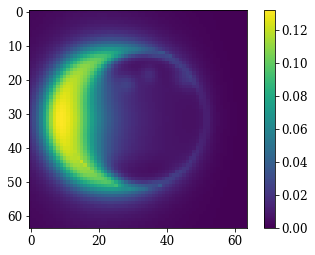

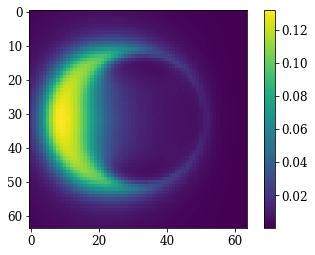

In [5]:
print(image_plane.shape)
plt.figure()
plt.imshow(image_plane[0,...], vmin=0.0)
plt.colorbar()

print(riaf_emission.imarr().shape) 
plt.figure()
plt.imshow(riaf_emission.imarr())
plt.colorbar()

In [ ]:
# EHT params
array_name = 'ngEHT'
fov = 85.0         # field of view in uas 
seed = None        # random seed for EHT measurement noise

# Load eht array
obs_params = {
    'array': eh.array.load_txt('../eht_arrays/{}.txt'.format(array_name)),
    'nt': 128,      # number of time samples 
    'tstart': 4.0,  # start of observations (UTC hr)
    'tstop': 15.5,  # end of observation (UTC hr)
    'tint': 60.0    # integration time
}
obs_empty = observation_utils.empty_eht_obs(**obs_params)

obs_args = {
    'psize': fov / sensor.num_alpha * ehc.RADPERUAS,
    'ra': obs_empty.ra, 
    'dec': obs_empty.dec,
    'rf': obs_empty.rf, 
    'mjd': obs_empty.mjd
}

times = np.linspace(obs_params['tstart'], obs_params['tstop'], nt)
times_test = np.linspace(obs_params['tstart'], obs_params['tstop'], nt_test)

movie = eh.movie.Movie(image_plane, times, **obs_args)
movie_test = eh.movie.Movie(image_plane, times_test, **obs_args)
# riaf_emission = eh.image.Image(np.zeros_like(image_plane[0]), **obs_args)
riaf_emission = eh.image.Image(riaf_emission.imarr(), **obs_args)

# Generate visibility measurements with noise
obs = observation_utils.observe_same(movie, obs_empty, ttype='direct', seed=seed)
obs_test = observation_utils.observe_same(movie_test, obs_empty, ttype='direct', seed=seed)
obs_riaf = riaf_emission.observe_same_nonoise(obs_empty, ttype='direct')

measurements = observation_utils.padded_obs(obs, 'vis', fill_value=0.0)
measurements_test = observation_utils.padded_obs(obs_test, 'vis', fill_value=0.0)

sigma = observation_utils.padded_obs(obs, 'sigma', fill_value=np.inf)
sigma_test = observation_utils.padded_obs(obs, 'sigma', fill_value=np.inf)

uv = np.stack((observation_utils.padded_obs(obs, 'u'), 
               observation_utils.padded_obs(obs, 'v')), axis=2)

ft_mats = np.stack([ftmatrix(movie.psize, movie.xdim, movie.ydim, uv_t, pulse=movie.pulse) for uv_t in uv])
ft_mats = np.nan_to_num(ft_mats, 0.0)
obs_times = np.array([np.mean(obsdata['time'][0]) for obsdata in obs.tlist()])

Producing clean visibilities from movie with direct FT . . . 


/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(datalist)


Applying Jones Matrices to data . . . 
Applying Jones Matrices to data . . . 
Adding thermal noise to data . . . 
Applying a priori calibration with estimated Jones matrices . . . 
Producing clean visibilities from movie with direct FT . . . 
Applying Jones Matrices to data . . . 
Applying Jones Matrices to data . . . 
Adding thermal noise to data . . . 
Applying a priori calibration with estimated Jones matrices . . . 
Producing clean visibilities from image with direct FT . . . 


In [75]:
%matplotlib widget
image_plane_xr = xr.DataArray(image_plane, dims=['t', 'alpha', 'beta'])

plt.rcdefaults()
fig, ax = plt.subplots(1,2, figsize=(9.5,4))
anim = image_plane_xr.utils_visualization.animate(ax=ax[0])
obs.plotall('uvdist', 'amp', axis=ax[1], label='total', ebar=False,  legend=True)
obs_riaf.plotall('uvdist', 'amp', axis=ax[1], label='background', ebar=False, color='r', legend=True, marker='^')
#ax[1].set_ylim([0, 2.5])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/scratch/imaging/projects/bh_nerf/bhNeRF/notebooks/../bhnerf/visualization.py:167: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


<AxesSubplot:xlabel='$u-v$ Distance', ylabel='Amplitude'>

In [11]:
def intensity_to_nchw(intensity, cmap='viridis', gamma=0.5):
    cm = plt.get_cmap(cmap)
    norm_images = ( (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity)) )**gamma
    nchw_images = np.moveaxis(cm(norm_images)[...,:3], (0, 1, 2, 3), (3, 2, 0, 1))
    return nchw_images

def train_network(sensor, emission_true, emission_test, velocity_field, obs_times, hparams, runname, 
                  log_period=100, save_period=10000, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    bg_image = jnp.array(riaf_emission.imarr(), dtype=np.float32)
    tstart = obs_times[0]
    tstop = obs_times[-1]

    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    t, x, y, z, d = train_coords.values()
    train_vis = measurements

    test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    test_vis = measurements_test
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = hparams['batchsize']
    emission_extent = [emission_true.x[0], emission_true.x[-1], emission_true.y[0], emission_true.y[-1], emission_true.z[0], emission_true.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(np.full(t_res_vis, fill_value=tstart), 
                                              np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
    r_min = hparams['r_min']                     # Zero network output where there is no supervision (within black-hole radius)  
    r_max = hparams['r_max']
    
    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_AND_MLP_ROTAXIS_3D_FROM_VIS_W_BG(posenc_deg=hparams['posenc_deg'])
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, tstart, tstop)['params']
    tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
    
    if np.isscalar(save_period):
        checkpoint_dir = 'checkpoints/{}'.format(runname)
        state = checkpoints.restore_checkpoint(checkpoint_dir, state)
    init_step = 1 + state.step
    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, 0, 0, None, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, 0, 0, None, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)

    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
       
    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images_true = intensity_to_nchw(emission_true.isel(t=0))

        for i in tqdm(range(init_step, init_step+hparams['num_iters']), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:
                batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)

                loss_test, _, _, rendering_test, _, _ = eval_pstep(
                    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(ft_mats[batch_inds, ...]),
                    tstart, tstop, shard(test_vis[batch_inds,...]),  shard(sigma_test[batch_inds, ...]), 
                    bg_image, state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(loss_test)), global_step=i)
                
                # Log prediction and estimate
                _, _, emission_vis, _, axis_estimation, _ = eval_pstep(
                    velocity_field, i, shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis),
                    shard(ft_mats[batch_inds, ...]), tstart, tstop, shard(test_vis[batch_inds,...]),
                    shard(sigma_test[batch_inds, ...]), bg_image, state, rand_key
                )
                axis_estimation = axis_estimation[0] / np.sqrt(np.dot(axis_estimation[0], axis_estimation[0]))
                emission_vis = np.reshape(emission_vis[0,0], [x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 < r_min**2, jnp.zeros_like(emission_vis), emission_vis)
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 > r_max**2, jnp.zeros_like(emission_vis), emission_vis)
                
                
                # Log emission and rotation axis
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_images('emission/true', images_true, global_step=i)
                emission_mse = float(np.mean((emission.data[0] - emission_vis)**2))
                emission_psnr =  float(10.0 * np.log10(np.max(emission.data[0])**2 / emission_mse))
                writer.add_scalar('emission_mse', emission_mse, global_step=i)
                writer.add_scalar('emission_psnr', emission_psnr, global_step=i)
                writer.add_image('input_bg', bg_image[None, ...], global_step=i)
                writer.add_image('rendering/test', rendering_test[0, 0, None, :, :], global_step=i)
                writer.add_image('rendering/true', image_plane_test[batch_inds[0], None, ...], global_step=i)
                writer.add_image('rendering/diff', np.abs(image_plane_test[batch_inds[0], None, ...] - rendering_test[0, 0, None, :, :]), global_step=i)
                writer.add_scalar('rotation/dot_product', np.dot(rot_axis, axis_estimation), global_step=i)
                writer.add_scalar('rotation/x', axis_estimation[0], global_step=i)
                writer.add_scalar('rotation/y', axis_estimation[1], global_step=i)
                writer.add_scalar('rotation/z', axis_estimation[2], global_step=i)
                
            # Training
            batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)
            loss_train, state, _, _, _, rand_key = train_pstep(
                velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(ft_mats[batch_inds, ...]), tstart, tstop,
                shard(train_vis[batch_inds, ...]), shard(sigma[batch_inds, ...]), bg_image, state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(np.mean(loss_train)), global_step=i)
    
            
            if np.isscalar(save_period) and ((i % save_period == 0) or (i == hparams['num_iters'])):
                state_to_save = jax.device_get(jax.tree_map(lambda x: x[0], state))
                checkpoints.save_checkpoint(checkpoint_dir, state_to_save, int(i), keep=5)
            
    return state, emission_vis, axis_estimation

In [25]:
def intensity_to_nchw(intensity, cmap='viridis', gamma=0.5):
    cm = plt.get_cmap(cmap)
    norm_images = ( (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity)) )**gamma
    nchw_images = np.moveaxis(cm(norm_images)[...,:3], (0, 1, 2, 3), (3, 2, 0, 1))
    return nchw_images

def train_network(sensor, emission_true, emission_test, velocity_field, obs_times, hparams, runname, 
                  log_period=100, save_period=10000, x_res_vis=64, y_res_vis=64, z_res_vis=64):
    
    bg_image = jnp.array(riaf_emission.imarr(), dtype=np.float32)
    tstart = obs_times[0]
    tstop = obs_times[-1]

    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    t, x, y, z, d = train_coords.values()
    train_vis = measurements

    test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
    test_vis = measurements_test
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = hparams['batchsize']
    emission_extent = [emission_true.x[0], emission_true.x[-1], emission_true.y[0], emission_true.y[-1], emission_true.z[0], emission_true.z[-1]]
    t_vis, x_vis, y_vis, z_vis  = np.meshgrid(np.full(t_res_vis, fill_value=tstart), 
                                              np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                              np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                              np.linspace(emission_extent[4], emission_extent[5], x_res_vis),
                                              indexing='ij')

    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
    r_min = hparams['r_min']                     # Zero network output where there is no supervision (within black-hole radius)  
    r_max = hparams['r_max']
    
    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_AND_MLP_ROTAXIS_3D_FROM_VIS_W_BG(posenc_deg=hparams['posenc_deg'])
    params = predictor.init(rng, x[:1, ...], y[:1, ...], z[:1, ...], t[:1, ...], velocity_field, tstart, tstop)['params']
    tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy
    
    if np.isscalar(save_period):
        checkpoint_dir = 'checkpoints/{}'.format(runname)
        state = checkpoints.restore_checkpoint(checkpoint_dir, state)
    init_step = 1 + state.step
    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, 0, 0, None, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, None, None, 0, 0, None, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)

    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
       
    with SummaryWriter(logdir=logdir) as writer:

        # Log ground-truth data   
        %matplotlib inline
        images_true = intensity_to_nchw(emission_true.isel(t=0))

        for i in tqdm(range(init_step, init_step+hparams['num_iters']), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:
                batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)

                loss_test, _, _, rendering_test, _, _ = eval_pstep(
                    velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                    shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(ft_mats[batch_inds, ...]),
                    tstart, tstop, shard(test_vis[batch_inds,...]),  shard(sigma_test[batch_inds, ...]), 
                    bg_image, state, rand_key
                )
                writer.add_scalar('log loss/test', np.log10(np.mean(loss_test)), global_step=i)
                
                # Log prediction and estimate
                _, _, emission_vis, _, axis_estimation, _ = eval_pstep(
                    velocity_field, i, shard(x_vis), shard(y_vis), shard(z_vis), shard(d_vis), shard(t_vis),
                    shard(ft_mats[batch_inds, ...]), tstart, tstop, shard(test_vis[batch_inds,...]),
                    shard(sigma_test[batch_inds, ...]), bg_image, state, rand_key
                )
                axis_estimation = axis_estimation[0] / np.sqrt(np.dot(axis_estimation[0], axis_estimation[0]))
                emission_vis = np.reshape(emission_vis[0,0], [x_res_vis, y_res_vis, z_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 < r_min**2, jnp.zeros_like(emission_vis), emission_vis)
                emission_vis = jnp.where(x_vis**2 + y_vis**2 + z_vis**2 > r_max**2, jnp.zeros_like(emission_vis), emission_vis)
                
                
                # Log emission and rotation axis
                images = intensity_to_nchw(emission_vis[0])
                writer.add_images('emission/estimate', images, global_step=i)
                writer.add_images('emission/true', images_true, global_step=i)
                emission_mse = float(np.mean((emission.data[0] - emission_vis)**2))
                emission_psnr =  float(10.0 * np.log10(np.max(emission.data[0])**2 / emission_mse))
                writer.add_scalar('emission_mse', emission_mse, global_step=i)
                writer.add_scalar('emission_psnr', emission_psnr, global_step=i)
                writer.add_image('input_bg', bg_image[None, ...], global_step=i)
                vmax = np.max(image_plane_test[batch_inds[0], None, ...] )
                writer.add_image('rendering/test', rendering_test[0, 0, None, :, :] / vmax, global_step=i)
                writer.add_image('rendering/true', image_plane_test[batch_inds[0], None, ...] / vmax, global_step=i)
                writer.add_image('rendering/diff', np.abs(image_plane_test[batch_inds[0], None, ...] - rendering_test[0, 0, None, :, :]), global_step=i)
                writer.add_scalar('rotation/dot_product', np.dot(rot_axis, axis_estimation), global_step=i)
                writer.add_scalar('rotation/x', axis_estimation[0], global_step=i)
                writer.add_scalar('rotation/y', axis_estimation[1], global_step=i)
                writer.add_scalar('rotation/z', axis_estimation[2], global_step=i)
                
            # Training
            batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)
            loss_train, state, _, _, _, rand_key = train_pstep(
                velocity_field, i, shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), shard(z[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), shard(ft_mats[batch_inds, ...]), tstart, tstop,
                shard(train_vis[batch_inds, ...]), shard(sigma[batch_inds, ...]), bg_image, state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(np.mean(loss_train)), global_step=i)
    
            
            if np.isscalar(save_period) and ((i % save_period == 0) or (i == hparams['num_iters'])):
                state_to_save = jax.device_get(jax.tree_map(lambda x: x[0], state))
                checkpoints.save_checkpoint(checkpoint_dir, state_to_save, int(i), keep=5)
            
    return state, emission_vis, axis_estimation

In [26]:
# Training params
hparams = {
    'num_iters': 5000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'posenc_deg': 3,
    'batchsize': 6,
    'r_min': r_min,
    'r_max': r_max,
}

runname = 'test/test1'
state, emission_vis, rot_axis_est = train_network(
    sensor, emission, emission_test, velocity_field, obs_times, hparams, 
    runname=runname, log_period=100, save_period=None, x_res_vis=64, y_res_vis=64, z_res_vis=64
)

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


iteration:   0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## DEBUG

In [13]:
# Training / testing coordinates
train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
t, x, y, z, d = train_coords.values()
batch_inds = np.random.choice(range(x.shape[0]), hparams['batchsize'], replace=False)
shard(uv[batch_inds, ...]).shape

(3, 2)

In [ ]:
bg_image = jnp.array(riaf_emission.imarr(), dtype=np.float32)
tstart = obs_times[0]
tstop = obs_times[-1]

# Training / testing coordinates
train_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
t, x, y, z, d = train_coords.values()
train_vis = measurements

test_coords = network_utils.get_input_coords(sensor, t_array=obs_times, batch='t')
test_vis = measurements_test
t_test, x_test, y_test, z_test, d_test = test_coords.values()

In [99]:
use_jax=False
images=image_plane
u=uv[...,0]
v=uv[...,1]
from observation_utils import trianglePulse2D, extra_phase

if use_jax == True:
    _np = jnp
    _nd = jnd
    interp_order = 1
else:
    _np = np
    _nd = nd
    interp_order = 3
    
# Pad image according to pad factor (interpolation in Fourier space)
if images.ndim == 2:
    images = images[None,...]
nb, ny, nx = images.shape
b = np.tile(np.array(range(nb))[...,None], u.shape[-1]) # batch indices

# Compute visibilities
rad_per_uas = 4.848136811094136e-12
psize = fov / nx * rad_per_uas
freqs = _np.fft.fftshift(_np.fft.fftfreq(n=nx, d=psize))
fft = _np.fft.fftshift(_np.fft.fft2(_np.fft.ifftshift(images)))

# Extra phase to match centroid convention
pulsefac = trianglePulse2D(u, v, psize, use_jax=use_jax)
phase = extra_phase(u, v, psize, images.shape, use_jax=use_jax)
coords = _np.stack((v, u), axis=-1)

fov_uv = _np.array((freqs[-1]-freqs[0], freqs[-1]-freqs[0]))
fourier_image_coords = _np.concatenate((
    b[...,None], 
    utils.world_to_image_coords(coords, fov_uv, (nx, ny), use_jax=use_jax) + 0.5
), axis=-1)
visibilities = _nd.map_coordinates(fft, fourier_image_coords.T, order=interp_order).T
visibilities = visibilities * phase * pulsefac

# Generate visibility measurements with noise
obs = movie.observe_same(obs_empty, ttype='fast', fft_pad_factor=1)

test = []
for v in visibilities:
    test.extend(v[np.abs(v)>0.0])
test = np.array(test)

fig, axes = plt.subplots(1,2, figsize=(5.5,3))
axes[0].scatter(obs.data['vis'].real, test.real)
axes[1].scatter(obs.data['vis'].imag, test.imag)
axes[0].set_title('real')
axes[1].set_title('imag')
for ax in axes:
    ax.set_xlabel('ehtim')
    ax.set_ylabel('ours')
    
plt.tight_layout()

Producing clean visibilities from movie with fast FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [128]:
ft_mat_list = [
    ftmatrix(movie.psize, movie.xdim, movie.ydim, np.stack((data['u'], data['v'])).T, pulse=movie.pulse) 
    for data in obs.tlist()
]
    

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(datalist)


In [139]:
obs = movie.observe_same_nonoise(obs_empty, ttype='direct')
vis = np.concatenate([np.matmul(FT, image.ravel()) for FT, image in zip(ft_mat_list, image_plane)])

Producing clean visibilities from movie with direct FT . . . 


In [141]:
fig, axes = plt.subplots(1,2, figsize=(5.5,3))
axes[0].scatter(obs.data['vis'].real, vis.real)
axes[1].scatter(obs.data['vis'].imag, vis.imag)
axes[0].set_title('real')
axes[1].set_title('imag')
for ax in axes:
    ax.set_xlabel('ehtim')
    ax.set_ylabel('ours')
    
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## ngEHT / EHT2017

In [98]:
runname = 'eht_arrays/{}_nspots{:2.2f}_phi{:2.2f}_theta{:2.2f}'.format(array_name, nspots, phi, theta)
state, emission_vis, rot_axis_est = train_network(
    sensor, emission, emission_test, velocity_field, obs_times, hparams, 
    runname=runname, log_period=100, save_period=1000, x_res_vis=64, y_res_vis=64, z_res_vis=64
)

# save results
save_results = {
    'true_rot_axis': rot_axis.tolist(),
    'est_rot_axis': rot_axis_est.tolist(),
    'rot_axis_dotprod': float(np.dot(rot_axis, rot_axis_est)),
    'emission_mse': float(np.mean((emission_vis[0]-emission.isel(t=0))**2))
}
with open(os.path.join('checkpoints', runname, 'results.yml'), 'w') as outfile:
    yaml.dump(save_results, outfile)

# Save emission
emission.name = 'true'
emission_estimate = emission_utils.generate_orbit_3d(
    xr.DataArray(emission_vis[0], coords=emission.isel(t=0).coords), nt, velocity_field, rot_axis_est)
emission_estimate.name = 'estimated'
emission_ds = xr.merge([emission, emission_estimate])
emission_ds.to_netcdf(os.path.join('checkpoints', runname, 'emission_ds.nc'))

/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:390: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/scratch/imaging/projects/bh_nerf/envs/jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:377: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


iteration:   0%|          | 0/5000 [00:00<?, ?it/s]